In [2]:
--------------------------------------------------------------------------------
-- Loading dataset to ram and sorting triplets
--------------------------------------------------------------------------------
-- Alfredo Canziani, Apr 15
--------------------------------------------------------------------------------

require 'image'
require 'sys'
require 'xlua'

-- set to 1 if using GPU
cuda = 1
if cuda == 1 then
    require 'cunn'
    require 'cutorch'
end

torch.setdefaulttensortype('torch.FloatTensor')

local dataset = {}
local imageSide = 224


-- Loading the dataset to RAM --------------------------------------------------
if paths.filep('dataset.t7') then
   io.write('Loading whole data set. Please wait...'); io.flush()
   dataset = torch.load('dataset.t7')
   print(' Done.')
else
   -- This script uses pubfig83.v1.tgz from http://vision.seas.harvard.edu/pubfig83/
   -- split in train and test folders
   -- each containing identities folders with images inside.
   -- Format:
   -- datasetRoot/{train,test}/<celebrityName>
   local datasetPaths = {}
   datasetPaths.base = 'pubfig83'

   for _, t in ipairs {'train', 'test'} do
      print('Building ' .. t .. 'ing data set')

      datasetPaths[t] = datasetPaths.base .. '/' .. t .. '/'
      local identities = sys.ls(datasetPaths[t]):split('\n')
        print(identities)
      local dataSize = tonumber(sys.execute('find ' .. datasetPaths[t] .. ' -iname "*.jpg"| wc -l'))
        print(dataSize)
      dataset[t] = {
         data = torch.Tensor(dataSize, 3, imageSide, imageSide),
         label = torch.Tensor(dataSize),
         index = torch.Tensor(#identities, 2),
      }

        
      local count = 0
      for id, idName in ipairs(identities) do
         dataset[t].index[id][1] = count + 1
         for _, img in ipairs(sys.ls(datasetPaths[t] .. idName):split('\n')) do
            count = count + 1
            xlua.progress(count, dataSize)
            -- print(count, paths.concat(datasetPaths[t], idName, img))
            local original = image.load(paths.concat(datasetPaths[t], idName, img))
            local h = original:size(2)
            local w = original:size(3)
            local m = math.min(h, w)
            local y = math.floor((h - m) / 2)
            local x = math.floor((w - m) / 2)
            dataset[t].data[count] = image.scale(
               original[{ {}, {y + 1, y + m}, {x + 1, x + m} }],
               imageSide, imageSide
            )
            dataset[t].label[count] = id
         end
         dataset[t].index[id][2] = count
         collectgarbage()
      end
   end

   io.write('Saving whole data set to disk...'); io.flush()
   torch.save('dataset.t7', dataset)
   print(' Done.')
end


-- Private functions -----------------------------------------------------------
-- Training shuffle
local shuffle

-- New index table for t: train/test
local shuffleShuffle = function(t)
   shuffle = torch.randperm(dataset[t].data:size(1))
end


-- Get nb of (train and test) batches gives the batch size
local nbOfBatches = {}
local batchSize, pImgs
local getNbOfBatches = function(bS)
   batchSize = bS
   for _, t in ipairs {'train', 'test'} do
      nbOfBatches[t] = math.floor(dataset[t].data:size(1) / batchSize)
   end
   pImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   return nbOfBatches
end


-- Initialise the (train and test) embeddings
local embSize
local initEmbeddings = function(eS)
   embSize = eS
   for _, t in ipairs {'train', 'test'} do
      dataset[t].emb = torch.randn(dataset[t].data:size(1), embSize)
      dataset[t].emb = dataset[t].emb:cdiv(dataset[t].emb:norm(2, 2):repeatTensor(1, embSize))
        print(dataset[t])
   end
   print('Training and testing embeddings initialised with size ' .. embSize)
end


-- Get batch number nb for the t (train/test) dataset
-- <mode> by default is 'hard-neg' but can be set to 'soft-neg'
local pEmb
local getBatch = function(nb, t, mode, epoch)

   -- Main varialbles
   local aImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   local nImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   local emb = torch.Tensor(batchSize, embSize)

   -- Auxiliary variables
   local labels = torch.Tensor(batchSize)
   local offset = batchSize * (nb - 1)

   -- Populating anchor and positive images batches
   for i = 1, batchSize do
      local loc = shuffle[i + offset] -- original location in data set
      aImgs[i]  = dataset[t].data [loc]
      emb[i]    = dataset[t].emb  [loc]
      labels[i] = dataset[t].label[loc]
      if mode ~= 'soft-neg2' then
         pImgs[i]  = dataset[t].data [math.random(
            dataset[t].index[labels[i]][1],
            dataset[t].index[labels[i]][2]
         )]
      end
   end

   -- Populating negative images batche
   local mode = mode or 'hard-neg'
   if mode == 'hard-neg' then
      for i = 1, batchSize do
         local diff = emb - emb[{ {i} }]:expandAs(emb)
         local norms = diff:norm(2, 2):squeeze()
         norms[labels:eq(labels[i])] = norms:max()
         local _, nIdx = norms:min(1) -- closest n-emb to a-emb
         nImgs[i] = aImgs[nIdx[1]]
      end
   elseif mode == 'soft-neg1' then
      -- do nothing
   elseif mode == 'soft-neg2' then
      for i = 1, batchSize do
         local diff = emb - emb[{ {i} }]:expandAs(emb)
         local norms = diff:norm(2, 2):squeeze()
         norms = norms - torch.Tensor(batchSize):fill((emb[i]-pEmb[i]):norm())
         norms[labels:eq(labels[i])] = norms:max()
         norms[norms:lt(0)] = norms:max()
         local _, nIdx = norms:min(1) -- closest n-emb to a-emb
         nImgs[i] = aImgs[nIdx[1]]
      end
   else error('Negative populating <mode> not recognised!')
   end

   return {aImgs, pImgs, nImgs}

end


-- Moves the batch to the GPU's RAM
local toCuda = function(batch)
   require 'cutorch'
   for i in ipairs(batch) do batch[i] = batch[i]:cuda() end
end


-- Saves the embeddings emb for the nb batch of t (train/test) data set
local saveEmb = function(emb, nb, t, posEmb)
   local offset = batchSize * (nb - 1)
   for i = 1, batchSize do
      dataset[t].emb[shuffle[i + offset]] = emb[i]:float()
   end
   if posEmb then pEmb = posEmb:float() end
end

local getDataset = function()
    
end

-- Public functions ------------------------------------------------------------
return {
   select         = shuffleShuffle,
   getNbOfBatches = getNbOfBatches,
   initEmbeddings = initEmbeddings,
   getBatch       = getBatch,
   toCuda         = toCuda,
   saveEmb        = saveEmb,
}

Loading whole data set. Please wait...

 Done.	


In [3]:
torch.manualSeed(0)
math.randomseed(0)

data = require 'data'

-- Shuffling training data
data.select('train') -- or 'test'

-- Initialise embeddings
embDim = 5
data.initEmbeddings(embDim)

-- Get train and test number of batches
batchDim = 10
trainBatches = data.getNbOfBatches(batchDim).train
print('trainBatches: ', trainBatches)

-- Get training batch nb 1
batch = data.getBatch(1, 'train')
print('batch = {aImg, pImg, nImg}: ', batch)

-- Send batch to cuda
--collectgarbage()
--data.toCuda(batch)
--print('Batch sent to GPU memory')

-- Saving embeddings
data.saveEmb(torch.randn(batchDim, embDim), 1, 'train')
print('Embedding saved for fast training')


Loading whole data set. Please wait...

 Done.	


Training and testing embeddings initialised with size 5	


trainBatches: 	1044	


batch = {aImg, pImg, nImg}: 	{
  1 : FloatTensor - size: 10x3x224x224
  2 : FloatTensor - size: 10x3x224x224
  3 : FloatTensor - size: 10x3x224x224
}
Embedding saved for fast training	


In [4]:
function printTriplets(batch)
    for i = 1, 10 do
            itorch.image({image.scale(batch[1][i], 48, 48), image.scale(batch[2][i], 48, 48), 
                image.scale(batch[3][i], 48, 48)})
    end
end

batch = {aImg, pImg, nImg}: 	{
  1 : FloatTensor - size: 10x3x224x224
  2 : FloatTensor - size: 10x3x224x224
  3 : FloatTensor - size: 10x3x224x224
}


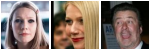

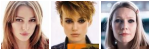

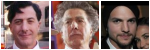

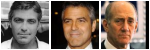

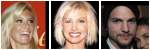

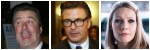

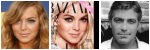

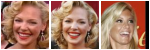

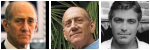

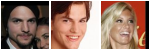

In [5]:

batch = data.getBatch(138, 'train')
print('batch = {aImg, pImg, nImg}: ', batch)
printTriplets(batch)

In [6]:
require 'nn'
alexnet = torch.load('alexnetowtbn_epoch55_cpu.t7')

In [7]:
function createModel(alexnet)
--     local alexnet = createModelAlex()
    --convNet = createModelAlex()
    local alexnet = alexnet:clone()
    alexnet:evaluate()
    alexnet:get(2):remove()
    alexnet:get(2):remove()
    alexnet:get(2):remove()
    alexnet:get(2):remove()

    convNet = alexnet
    convNet:get(2):add(nn.View(4096))
    convNet:get(2):add(nn.Linear(4096, 128))
    convNet:get(2):add(nn.Normalize(2))
    convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(convNet)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)
    return parallel
end

function createModelTrip()
    embeddingSize = 3
    convNet = nn.Sequential()
    convNet:add(nn.SpatialConvolution(3, 8, 5, 5))
    convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
    convNet:add(nn.ReLU())
    convNet:add(nn.SpatialConvolution(8, 8, 5, 5))
    convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
    convNet:add(nn.ReLU())
    convNet:add(nn.View(8*2*2))
    convNet:add(nn.Linear(8*2*2, embeddingSize))
    convNet:add(nn.BatchNormalization(embeddingSize))
    
    convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(convNet)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)
    return parallel:cuda()
end


function computeSimilarity(x, y)
--     -- use L2 norm distance
--     diff = x - y
--     return diff:norm(2,1):pow(2)
--     local dist_sum = 0
--     for i = 1, 128 do
--         dist_sum += x[i] 
    return torch.dist(x, y)
end

In [8]:
imgDim = 224

local conv = nn.SpatialConvolutionMM
local relu = nn.ReLU
local mp = nn.SpatialMaxPooling

function createModelVGG()
   local net = nn.Sequential()

   net:add(conv(3, 64, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(64, 64, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(64, 128, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(128, 128, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(128, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(256, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))

   -- Validate shape with:
   -- net:add(nn.Reshape(25088))

   net:add(nn.View(25088))
   net:add(nn.Linear(25088, 4096))
   net:add(relu(true))

   net:add(nn.Linear(4096, 128))
   net:add(nn.Normalize(2))
    
    convNetPos = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(net)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)

    return parallel
end

function createModelAlex()
    local net = nn.Sequential()
    local fb1 = nn.Sequential()
    fb1:add(nn.SpatialConvolution(3,64,11,11,4,4,2,2))       -- 224 -> 55
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   -- 55 ->  27
    fb1:add(nn.SpatialConvolution(64,192,5,5,1,1,2,2))       --  27 -> 27
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   --  27 ->  13
    fb1:add(nn.SpatialConvolution(192,384,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialConvolution(384,256,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialConvolution(256,256,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   -- 13 -> 6

    local classifier = nn.Sequential()
    classifier:add(nn.View(256*6*6))
    classifier:add(nn.Dropout(0.5))
    classifier:add(nn.Linear(256*6*6, 4096))
    classifier:add(nn.Threshold(0, 1e-6))
    classifier:add(nn.Dropout(0.5))
--     classifier:add(nn.View(4096))
    classifier:add(nn.Linear(4096, 128))
    classifier:add(nn.Normalize(2))
    
    net:add(fb1)
    net:add(classifier)
    return net
end

In [9]:
require 'nn'

--Load the AlexNet model
meanStd = torch.load('alexnetowtbn_meanStd.t7')

-- Pre-process the image channel by channel.
function preprocess(im)
    local output_image = image.scale(im:clone(), 224, 224)
    for i = 1, 3 do -- channels
        output_image[{{i},{},{}}]:add(-meanStd.mean[i])
        output_image[{{i},{},{}}]:div(meanStd.std[i])
    end
    return output_image
end

In [10]:
require 'nn'
require 'TripletEmbedding'

local criterion = nn.TripletEmbeddingCriterion()
if cuda == 1 then
    criterion = criterion:cuda()
end

function trainModel(model, opt)
    if cuda == 1 then
        print("loading model onto GPU")
        model = model:cuda()
    end
    
    -- Get all the parameters (and gradients) of the model in a single vector.
    print("getting params")
    -- local params, gradParams = model:getParameters()
    local singleNet = model.modules[1]
    local opt = opt or {}
    local batchSize = opt.batchSize or 10  -- The bigger the batch size the most accurate the gradients.
    local numEpochs = opt.numEpochs or 3
    print("getting batches")
    local trainBatches = data.getNbOfBatches(batchSize).train
    print('trainBatches: ', trainBatches)
    local numEpochs = trainBatches
    -- Go over the training data this number of times.
    local inputs = data.getBatch(1, 'train')
     for epoch = 1, 10 do
        local sum_loss = 0
        local correct = 0
--         local inputs = data.getBatch(1, 'train')

        -- Run over the training set samples.
        -- set internal var Train=True so that layers like Dropout behave correctly. Also see :evaluate()
        
--         model:training()
        
        -- 2. Perform the forward pass (prediction mode).
        --:view(1, 3, 224, 224)
        -- Ancore training samples/images
        local imageDim = 20
        local batch = 10
        aImgs = torch.rand(batch, 3, imageDim, imageDim):cuda()
        pImgs = torch.rand(batch, 3, imageDim, imageDim):cuda()
        -- Negative training samples/images
        nImgs = torch.rand(batch, 3, imageDim, imageDim):cuda()
--         print(nImgs)
        
        
        wrapperTotal = torch.Tensor(3, 10, 3, imageDim, imageDim)
        
        for apn = 1, 3 do
            for batchN = 1, batchSize do
                wrapper = torch.Tensor(1, 3, imageDim, imageDim)
                wrapper[1] = image.scale(inputs[apn][batchN], imageDim, imageDim)
                wrapperTotal[apn][batchSize] = wrapper
            end
        end
--         wrapperTotal = {inputs[1], inputs[2], inputs[3]}
--         wrapperTotal = inputs
        
--         print(image.scale(inputs[1], imageDim, imageDim))
--         print('haha')
        if cuda == 1 then
            wrapperTotal = wrapperTotal:cuda()
        end
--         print(inputs)
--         print(inputs:size())
--         print({wrapperTotal[1], wrapperTotal[2], wrapperTotal[3]})
--         local predictions = model:forward({wrapperTotal[1], wrapperTotal[2], wrapperTotal[3]})
        print({aImgs, pImgs, nImgs})
        local predictions = model:forward({aImgs, pImgs, nImgs})
--         print('haha1')
        print(predictions)
        --print("passed")
        -- 3. Evaluate results.
        --for i = 1, predictions:size(1) do
        --    local _, predicted_label = predictions[i]:max(1)
        --    if predicted_label[1] == labels[i] then correct = correct + 1 end
        --end
        local sum_loss = sum_loss + criterion:forward(predictions)
--         print("passed stage 2")
        -- TODO: need to figure out how to change this to accomandate the BCECriterion
        -- 4. Perform the backward pass (compute derivatives).
        -- This zeroes-out all the parameters inside the model pointed by variable params.
        
--          print("passed stage 3")
        -- This internally computes the gradients with respect to the parameters pointed by gradParams.
        local gradPredictions = criterion:backward(predictions)
        model:zeroGradParameters()
--          print("passed stage 4")
        --{wrapper, wrapper2, wrapper3}
        model:backward({aImgs, pImgs, nImgs}, gradPredictions)
        model:updateParameters(0.01)
--          print("passed stage 5")
         -- 5. Perform the SGD update.
        if epoch % 100 == 0 then
            model:updateParameters(0.01)
        end
        
        if epoch % 10 == 0 then  -- Print this every 10 epochs.
            print(('train epoch=%d, avg-loss=%.6f')
                :format(epoch, sum_loss / epoch))
        end

        -- Run over the validation set for evaluation.
        print(epoch)
        itorch.image({image.scale(inputs[1][1], 48, 48), image.scale(inputs[2][1], 48, 48), 
                image.scale(inputs[3][1], 48, 48)})
        
        if epoch == 1 then
            print(predictions[1][1])
        end
        
        local ap = computeSimilarity(predictions[1][1], predictions[2][1])
        local an = computeSimilarity(predictions[1][1], predictions[3][1])
        print(('\na-->p %.4f'):format(ap))
        print(('\na-->n %.4f'):format(an))
        --print(('\nvalidation accuracy at epoch = %d is %.4f'):format(epoch, validation_accuracy))
    end
end

In [11]:
model = createModelTrip()


loading model onto GPU	
getting params	
getting batches	
trainBatches: 	1044	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


1	


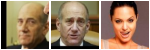

 0.3996
-0.0381
-0.1339
[torch.CudaTensor of size 3]




a-->p 0.5736	

a-->n 0.7923	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


2	


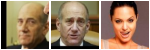


a-->p 2.2144	

a-->n 2.5051	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


3	


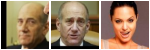


a-->p 0.9303	

a-->n 0.2578	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


4	


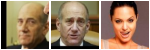


a-->p 0.6228	

a-->n 1.6830	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


5	


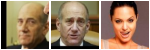


a-->p 0.9245	

a-->n 1.7953	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


6	


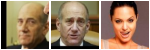


a-->p 2.2490	

a-->n 0.9463	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


7	


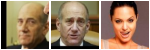


a-->p 0.7845	

a-->n 0.2351	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


8	


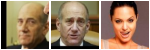


a-->p 0.9178	

a-->n 0.8303	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


9	


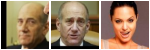


a-->p 0.2649	

a-->n 1.3553	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=10, avg-loss=0.053487	
10	


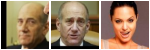


a-->p 1.1866	

a-->n 0.8127	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


11	


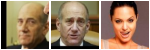


a-->p 0.4297	

a-->n 0.6533	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


12	


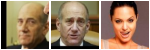


a-->p 1.0609	

a-->n 0.4393	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


13	


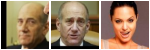


a-->p 0.3399	

a-->n 0.1465	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


14	


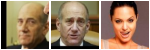


a-->p 0.6734	

a-->n 0.2571	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


15	


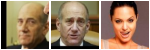


a-->p 0.6220	

a-->n 0.3543	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


16	


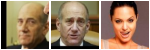


a-->p 0.6788	

a-->n 0.5402	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


17	


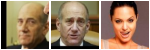


a-->p 0.5507	

a-->n 0.7994	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


18	


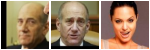


a-->p 0.3852	

a-->n 0.7050	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


19	


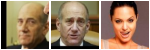


a-->p 0.3300	

a-->n 0.4089	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=20, avg-loss=0.011183	
20	


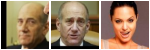


a-->p 0.4749	

a-->n 0.6901	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


21	


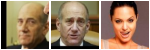


a-->p 0.6922	

a-->n 0.4151	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


22	


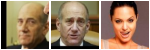


a-->p 0.5840	

a-->n 0.7617	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


23	


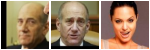


a-->p 0.4747	

a-->n 0.0828	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


24	


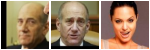


a-->p 0.2674	

a-->n 0.3196	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


25	


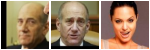


a-->p 0.0910	

a-->n 0.5802	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


26	


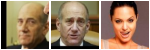


a-->p 0.4129	

a-->n 0.1989	


{


  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}
{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


27	


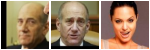


a-->p 0.4459	

a-->n 0.2936	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


28	


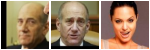


a-->p 0.2543	

a-->n 0.3501	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


29	


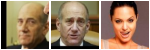


a-->p 0.5198	

a-->n 0.5744	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=30, avg-loss=0.005319	
30	


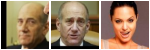


a-->p 0.2892	

a-->n 0.1518	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


31	


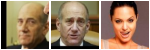


a-->p 0.2996	

a-->n 0.1773	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


32	


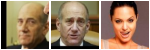


a-->p 0.1516	

a-->n 0.2850	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


33	


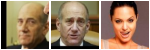


a-->p 0.5652	

a-->n 0.2073	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


34	


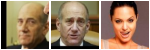


a-->p 0.2255	

a-->n 0.3318	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


35	


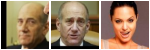


a-->p 0.0940	

a-->n 0.0839	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


36	


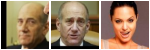


a-->p 0.4014	

a-->n 0.4017	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}
{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


37	


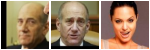


a-->p 0.1285	

a-->n 0.3873	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


38	


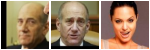


a-->p 0.2410	

a-->n 0.3926	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


39	


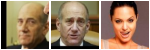


a-->p 0.3589	

a-->n 0.2347	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=40, avg-loss=0.005362	
40	


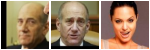


a-->p 0.2753	

a-->n 0.3187	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


41	


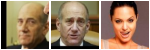


a-->p 0.1748	

a-->n 0.2500	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


42	


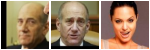


a-->p 0.2714	

a-->n 0.1190	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


43	


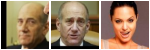


a-->p 0.4324	

a-->n 0.1934	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


44	


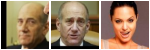


a-->p 0.1690	

a-->n 0.0965	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


45	


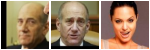


a-->p 0.2040	

a-->n 0.3701	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


46	


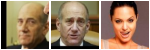


a-->p 0.1351	

a-->n 0.3055	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}
{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3


}


47	


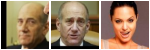


a-->p 0.1807	

a-->n 0.4170	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


48	


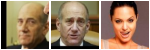


a-->p 0.2300	

a-->n 0.3319	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


49	


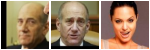


a-->p 0.2935	

a-->n 0.3552	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=50, avg-loss=0.004022	
50	


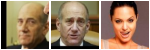


a-->p 0.3708	

a-->n 0.2727	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


51	


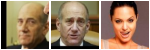


a-->p 0.3308	

a-->n 0.3095	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


52	


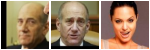


a-->p 0.1365	

a-->n 0.1367	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


53	


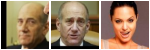


a-->p 0.2004	

a-->n 0.2530	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


54	


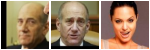


a-->p 0.2297	

a-->n 0.2216	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


55	


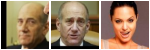


a-->p 0.3420	

a-->n 0.1013	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


56	


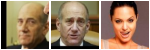


a-->p 0.2262	

a-->n 0.3286	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


57	


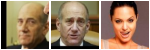


a-->p 0.3348	

a-->n 0.1962	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


58	


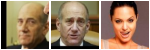


a-->p 0.3785	

a-->n 0.3341	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


59	


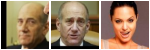


a-->p 0.0536	

a-->n 0.6242	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=60, avg-loss=0.002723	
60	


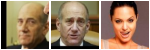


a-->p 0.4354	

a-->n 0.4570	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


61	


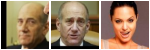


a-->p 0.2548	

a-->n 0.2227	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


62	


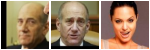


a-->p 0.1066	

a-->n 0.1866	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


63	


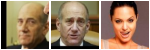


a-->p 0.4626	

a-->n 0.2172	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


64	


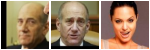


a-->p 0.1874	

a-->n 0.3294	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


65	


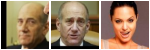


a-->p 0.3164	

a-->n 0.2562	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


66	


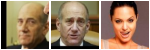


a-->p 0.1555	

a-->n 0.2999	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


67	


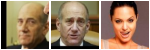


a-->p 0.1721	

a-->n 0.1141	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


68	


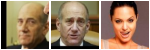


a-->p 0.2088	

a-->n 0.2321	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


69	


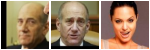


a-->p 0.1793	

a-->n 0.1802	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=70, avg-loss=0.002898	
70	


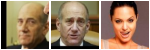


a-->p 0.3941	

a-->n 0.4174	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


71	


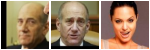


a-->p 0.3086	

a-->n 0.1961	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


72	


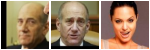


a-->p 0.1941	

a-->n 0.2485	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


73	


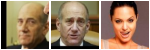


a-->p 0.3514	

a-->n 0.2022	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


74	


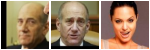


a-->p 0.1924	

a-->n 0.2073	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


75	


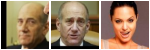


a-->p 0.0222	

a-->n 0.1426	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


76	


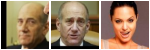


a-->p 0.1151	

a-->n 0.1309	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


77	


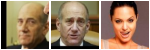


a-->p 0.1564	

a-->n 0.1269	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


78	


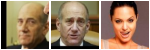


a-->p 0.1344	

a-->n 0.0738	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


79	


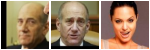


a-->p 0.3083	

a-->n 0.3214	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=80, avg-loss=0.002271	
80	


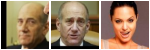


a-->p 0.2801	

a-->n 0.3062	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


81	


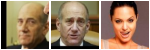


a-->p 0.1218	

a-->n 0.2029	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


82	


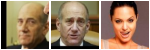


a-->p 0.2175	

a-->n 0.2616	


{
  1 : CudaTensor - size: 10x3x20x20


  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}
{


  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


83	


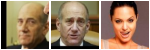


a-->p 0.1649	

a-->n 0.1525	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


84	


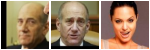


a-->p 0.1008	

a-->n 0.3386	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{


  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


85	


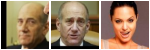


a-->p 0.2175	

a-->n 0.1489	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3


  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


86	


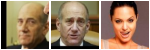


a-->p 0.1312	

a-->n 0.2939	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


87	


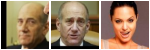


a-->p 0.1687	

a-->n 0.0672	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


88	


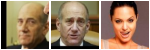


a-->p 0.1626	

a-->n 0.2035	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


89	


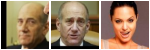


a-->p 0.1092	

a-->n 0.2442	


{


  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=90, avg-loss=0.002292	
90	


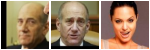


a-->p 0.2484	

a-->n 0.2402	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


91	


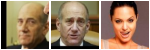


a-->p 0.3662	

a-->n 0.2236	


{
  1 : CudaTensor - size: 10x3x20x20
 

 2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}
{
  1 : CudaTensor - size: 10x3


  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


92	


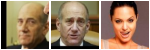


a-->p 0.1918	

a-->n 0.0819	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


93	


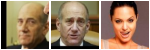


a-->p 0.1547	

a-->n 0.2661	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


94	


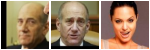


a-->p 0.4210	

a-->n 0.4275	


{
  1 : CudaTensor - size: 10x3x20x20


  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


95	


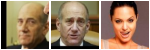


a-->p 0.2963	

a-->n 0.1822	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


96	


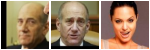


a-->p 0.0262	

a-->n 0.2398	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{


  1 : CudaTensor - size: 10x3


  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


97	


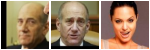


a-->p 0.3023	

a-->n 0.1088	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3


  3 : CudaTensor - size: 10x3
}


98	


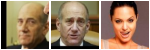


a-->p 0.1244	

a-->n 0.2052	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


99	


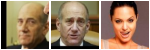


a-->p 0.1158	

a-->n 0.1739	


{
  1 : CudaTensor - size: 10x3x20x20


  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=100, avg-loss=0.002154	
100	


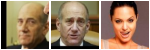


a-->p 0.2222	

a-->n 0.3334	



In [13]:
trainModel(model:clone(), {})

In [14]:
--------------------------------------------------------------------------------
-- Fresh embedding training example
--------------------------------------------------------------------------------
-- Alfredo Canziani, Apr 15
--------------------------------------------------------------------------------

-- package.path = "../?.lua;" .. package.path

require 'nn'
require 'TripletEmbedding'
colour = require 'trepl.colorize'
local b = colour.blue

torch.manualSeed(0)

local learningRate = 0.1
local batchSize = 10
local embeddingSize = 3
local imgSize = 96
local trainBatches = data.getNbOfBatches(batchSize).train




-- Network definition
-- convNet = nn.Sequential()
-- convNet:add(nn.SpatialConvolution(3, 8, 5, 5))
-- convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
-- convNet:add(nn.ReLU())
-- convNet:add(nn.SpatialConvolution(8, 8, 5, 5))
-- convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
-- convNet:add(nn.ReLU())
-- convNet:add(nn.View(8*2*2))
-- convNet:add(nn.Linear(8*2*2, embeddingSize))
-- convNet:add(nn.BatchNormalization(embeddingSize))

-- convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
-- convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')

-- -- Parallel container
-- parallel = nn.ParallelTable()
-- parallel:add(convNet)
-- parallel:add(convNetPos)
-- parallel:add(convNetNeg)
-- parallel = parallel:cuda()

local conv = nn.SpatialConvolutionMM
local sbn = nn.SpatialBatchNormalization
local relu = nn.ReLU
local mp = nn.SpatialMaxPooling

 local net = nn.Sequential()

   net:add(conv(3, 64, 3,3, 1,1, 1,1))
   net:add(sbn(64))
   net:add(relu(true))
   net:add(conv(64, 64, 3,3, 1,1, 1,1))
   net:add(sbn(64))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(64, 128, 3,3, 1,1, 1,1))
   net:add(sbn(128))
   net:add(relu(true))
   net:add(conv(128, 128, 3,3, 1,1, 1,1))
   net:add(sbn(128))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(128, 256, 3,3, 1,1, 1,1))
   net:add(sbn(256))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(sbn(256))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(sbn(256))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(256, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))

   -- Validate shape with:
   net:add(nn.Reshape(4608))

   net:add(nn.View(4608))
   net:add(nn.Linear(4608, 1024))
   net:add(relu(true))

   net:add(nn.Linear(1024, 64))
   net:add(nn.Normalize(2))
    
    convNetPos = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(net)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)
    parallel = parallel:cuda()
-- print(b('Fresh-embeddings-computation network:')); print(parallel)

-- Cost function
loss = nn.TripletEmbeddingCriterion()
loss = loss:cuda()
local iterations = 50000
local sumErr = 0
local sumMeanP = 0
local sumMeanN = 0
local printVal = 100

for i = 1, iterations do
    local inputs = data.getBatch((i % trainBatches) + 1, 'train')

    local resize_inputs = {torch.Tensor(batchSize, 3, imgSize, imgSize),
        torch.Tensor(batchSize, 3, imgSize, imgSize),
        torch.Tensor(batchSize, 3, imgSize, imgSize)}

    for apn = 1, 3 do
        for imgN = 1, batchSize do
            resize_inputs[apn][imgN] = image.scale(inputs[apn][imgN], imgSize, imgSize)
        end
    end
    --print('pass')
    aImgs = resize_inputs[1]
    -- Positive training samples/images
    pImgs = resize_inputs[2]
    -- Negative training samples/images
    nImgs = resize_inputs[3]
    
    local inputs = {aImgs, pImgs, nImgs}
   predict = parallel:forward({aImgs:cuda(), pImgs:cuda(), nImgs:cuda()})
    --print(inputs)
   err = loss:forward(predict)
   sumErr = sumErr + err
   errGrad = loss:backward(predict)
   parallel:zeroGradParameters()
   parallel:backward({aImgs:cuda(), pImgs:cuda(), nImgs:cuda()}, errGrad)
    
    if i == iterations/4 then
        learningRate = .01
    elseif i == (iterations/10)*6 then
        learningRate = .001
    elseif i == (iterations/10)*9 then
        learningRate = .0001
    elseif i == iterations-(iterations/100) then
        learningRate = .00001
    end
   parallel:updateParameters(learningRate)
    local mean_ap = 0
    local mean_an = 0
    for j = 1, batchSize do
        local ap = computeSimilarity(predict[1][j], predict[2][j])
        local an = computeSimilarity(predict[1][j], predict[3][j])
        mean_ap = mean_ap + ap
        mean_an = mean_an + an
    end
    mean_ap = mean_ap / batchSize
    mean_an = mean_an / batchSize
    sumMeanP = sumMeanP + mean_ap
    sumMeanN = sumMeanN + mean_an
    
    
    if i%printVal == 0 then
        print(colour.green('Epoch ' .. i))
        print(('\na-->p %.6f'):format(sumMeanP/printVal))
        print(('\na-->n %.6f'):format(sumMeanN/printVal))
        print(colour.red('loss: '), ('%.6f'):format(sumErr/printVal))
        sumMeanP = 0
        sumMeanN = 0
        sumErr = 0
    end
        
        --    print(b('gradInput[1]:')); print(errGrad[1])\
end

local filename = "VGG_small_" .. tostring(iterations) .. ".t7"
torch.save(tostring(filename), parallel)

Epoch 100	

a-->p 0.167663	

a-->n 0.192822	
loss: 	0.195435	


Epoch 200	

a-->p 0.194459	

a-->n 0.214903	
loss: 	0.194523	


Epoch 300	

a-->p 0.206787	

a-->n 0.245180	
loss: 	0.185731	


Epoch 400	

a-->p 0.202855	

a-->n 0.245737	
loss: 	0.185237	


Epoch 500	

a-->p 0.223312	

a-->n 0.269936	
loss: 	0.183631	


Epoch 600	

a-->p 0.230265	

a-->n 0.294081	
loss: 	0.174111	


Epoch 700	

a-->p 0.240606	

a-->n 0.290502	
loss: 	0.180133	


Epoch 800	

a-->p 0.270268	

a-->n 0.339376	
loss: 	0.172850	


Epoch 900	

a-->p 0.269329	

a-->n 0.348073	
loss: 	0.166571	


Epoch 1000	

a-->p 0.249168	

a-->n 0.354135	
loss: 	0.157357	


Epoch 1100	

a-->p 0.281194	

a-->n 0.388228	
loss: 	0.155822	


Epoch 1200	

a-->p 0.284084	

a-->n 0.379497	
loss: 	0.158416	


Epoch 1300	

a-->p 0.276396	

a-->n 0.370947	
loss: 	0.157086	


Epoch 1400	

a-->p 0.277400	

a-->n 0.383956	
loss: 	0.151475	


Epoch 1500	

a-->p 0.283619	

a-->n 0.382858	
loss: 	0.156431	


Epoch 1600	

a-->p 0.281725	

a-->n 0.388957	
loss: 	0.153003	


Epoch 1700	

a-->p 0.298112	

a-->n 0.395147	
loss: 	0.155171	


Epoch 1800	

a-->p 0.273531	

a-->n 0.371815	
loss: 	0.157998	


Epoch 1900	

a-->p 0.275866	

a-->n 0.368404	
loss: 	0.159191	


Epoch 2000	

a-->p 0.261196	

a-->n 0.385299	
loss: 	0.145222	


Epoch 2100	

a-->p 0.271483	

a-->n 0.377399	
loss: 	0.152981	


Epoch 2200	

a-->p 0.284293	

a-->n 0.397951	
loss: 	0.147092	


Epoch 2300	

a-->p 0.296848	

a-->n 0.406357	
loss: 	0.149965	


Epoch 2400	

a-->p 0.286871	

a-->n 0.410513	
loss: 	0.143402	


Epoch 2500	

a-->p 0.285219	

a-->n 0.396665	
loss: 	0.150001	


Epoch 2600	

a-->p 0.282137	

a-->n 0.409099	
loss: 	0.143905	


Epoch 2700	

a-->p 0.285960	

a-->n 0.396160	
loss: 	0.149889	


Epoch 2800	

a-->p 0.273422	

a-->n 0.394293	
loss: 	0.145513	


Epoch 2900	

a-->p 0.280065	

a-->n 0.398332	
loss: 	0.144510	


Epoch 3000	

a-->p 0.296680	

a-->n 0.418943	
loss: 	0.146293	


Epoch 3100	

a-->p 0.274758	

a-->n 0.408492	
loss: 	0.142399	


Epoch 3200	

a-->p 0.276839	

a-->n 0.415386	
loss: 	0.140514	


Epoch 3300	

a-->p 0.273160	

a-->n 0.400558	
loss: 	0.143694	


Epoch 3400	

a-->p 0.293065	

a-->n 0.428051	
loss: 	0.139181	


Epoch 3500	

a-->p 0.286264	

a-->n 0.424359	
loss: 	0.139282	


Epoch 3600	

a-->p 0.284048	

a-->n 0.440702	
loss: 	0.130957	


Epoch 3700	

a-->p 0.279853	

a-->n 0.421597	
loss: 	0.138849	


Epoch 3800	

a-->p 0.300476	

a-->n 0.427995	
loss: 	0.143361	


Epoch 3900	

a-->p 0.298184	

a-->n 0.433229	
loss: 	0.140199	


Epoch 4000	

a-->p 0.295938	

a-->n 0.427703	
loss: 	0.141948	


Epoch 4100	

a-->p 0.266632	

a-->n 0.420940	
loss: 	0.132476	


Epoch 4200	

a-->p 0.285304	

a-->n 0.431121	
loss: 	0.137157	


Epoch 4300	

a-->p 0.288944	

a-->n 0.435428	
loss: 	0.135972	


Epoch 4400	

a-->p 0.301638	

a-->n 0.442389	
loss: 	0.140094	


Epoch 4500	

a-->p 0.287031	

a-->n 0.429025	
loss: 	0.136797	


Epoch 4600	

a-->p 0.300275	

a-->n 0.421640	
loss: 	0.143432	


Epoch 4700	

a-->p 0.304921	

a-->n 0.460937	
loss: 	0.130210	


Epoch 4800	

a-->p 0.297440	

a-->n 0.430266	
loss: 	0.137466	


Epoch 4900	

a-->p 0.283600	

a-->n 0.415679	
loss: 	0.141572	


Epoch 5000	

a-->p 0.300102	

a-->n 0.439396	
loss: 	0.139272	


Epoch 5100	

a-->p 0.291675	

a-->n 0.448093	
loss: 	0.132206	


Epoch 5200	

a-->p 0.298912	

a-->n 0.426826	
loss: 	0.144807	


Epoch 5300	

a-->p 0.280290	

a-->n 0.446893	
loss: 	0.127037	


Epoch 5400	

a-->p 0.302564	

a-->n 0.430518	
loss: 	0.141741	


Epoch 5500	

a-->p 0.293174	

a-->n 0.442737	
loss: 	0.130837	


Epoch 5600	

a-->p 0.301016	

a-->n 0.439623	
loss: 	0.134548	


Epoch 5700	

a-->p 0.314386	

a-->n 0.477205	
loss: 	0.125263	


Epoch 5800	

a-->p 0.307984	

a-->n 0.460432	
loss: 	0.130117	


Epoch 5900	

a-->p 0.310715	

a-->n 0.450054	
loss: 	0.133966	


Epoch 6000	

a-->p 0.304750	

a-->n 0.424666	
loss: 	0.143900	


Epoch 6100	

a-->p 0.322011	

a-->n 0.474521	
loss: 	

0.129193	


Epoch 6200	

a-->p 0.305898	



a-->n 0.477956	
loss: 	0.124149	


Epoch 6300	

a-->p 0.307111	

a-->n 0.467753	
loss: 	0.124902	


Epoch 6400	

a-->p 0.326373	

a-->n 0.484875	
loss: 	0.128263	


Epoch 6500	

a-->p 0.306149	

a-->n 0.449297	
loss: 	0.135285	


Epoch 6600	

a-->p 0.302885	

a-->n 0.475814	
loss: 	0.121915	


Epoch 6700	

a-->p 0.301977	

a-->n 0.443032	
loss: 	0.133440	


Epoch 6800	

a-->p 0.322521	

a-->n 0.490853	
loss: 	0.122607	


Epoch 6900	

a-->p 0.326911	

a-->n 0.468953	
loss: 	0.134616	


Epoch 7000	

a-->p 0.331134	

a-->n 0.457667	
loss: 	0.140838	


Epoch 7100	

a-->p 0.313587	

a-->n 0.460939	
loss: 	0.131581	


Epoch 7200	

a-->p 0.304574	

a-->n 0.456588	
loss: 	0.130201	


Epoch 7300	

a-->p 0.322065	

a-->n 0.496655	
loss: 	0.119493	


Epoch 7400	

a-->p 0.323163	

a-->n 0.513475	
loss: 	0.116083	


Epoch 7500	

a-->p 0.319053	

a-->n 0.478623	
loss: 	0.125870	


Epoch 7600	

a-->p 0.322355	

a-->n 0.504231	
loss: 	0.117393	


Epoch 7700	

a-->p 0.312582	

a-->n 0.473651	
loss: 	0.125166	


Epoch 7800	

a-->p 0.326117	

a-->n 0.512667	
loss: 	0.113613	


Epoch 7900	

a-->p 0.314357	

a-->n 0.475257	
loss: 	0.128887	


Epoch 8000	

a-->p 0.301937	

a-->n 0.462068	
loss: 	0.124264	


Epoch 8100	

a-->p 0.310627	

a-->n 0.452676	
loss: 	0.132149	


Epoch 8200	

a-->p 0.329140	

a-->n 0.501027	
loss: 	0.122100	


Epoch 8300	

a-->p 0.316212	

a-->n 0.498954	
loss: 	0.118120	


Epoch 8400	

a-->p 0.313977	

a-->n 0.515353	
loss: 	0.112164	


Epoch 8500	

a-->p 0.318668	

a-->n 0.487094	
loss: 	0.124717	


Epoch 8600	

a-->p 0.334015	

a-->n 0.514506	
loss: 	0.115532	


Epoch 8700	

a-->p 0.326767	

a-->n 0.514972	
loss: 	0.115178	


Epoch 8800	

a-->p 0.309231	

a-->n 0.494174	
loss: 	0.116932	


Epoch 8900	

a-->p 0.313288	

a-->n 0.520816	
loss: 	0.108019	


Epoch 9000	

a-->p 0.303130	

a-->n 0.463940	
loss: 	0.127175	


Epoch 9100	

a-->p 0.312476	

a-->n 0.467441	
loss: 	0.131016	


Epoch 9200	

a-->p 0.310858	

a-->n 0.504422	
loss: 	0.110297	


Epoch 9300	

a-->p 0.317410	

a-->n 0.528629	
loss: 	0.109171	


Epoch 9400	

a-->p 0.298422	

a-->n 0.500506	
loss: 	0.110916	


Epoch 9500	

a-->p 0.303600	

a-->n 0.547096	
loss: 	0.099020	


Epoch 9600	

a-->p 0.316504	

a-->n 0.521308	
loss: 	0.108836	


Epoch 9700	

a-->p 0.343383	

a-->n 0.550265	
loss: 	0.108297	


Epoch 9800	

a-->p 0.330745	

a-->n 0.519003	
loss: 	0.116197	


Epoch 9900	

a-->p 0.315105	

a-->n 0.541384	
loss: 	0.099782	


Epoch 10000	

a-->p 0.312633	

a-->n 0.506186	
loss: 	0.116453	


Epoch 10100	

a-->p 0.319900	

a-->n 0.515255	
loss: 	0.114773	


Epoch 10200	

a-->p 0.307945	



a-->n 0.486439	
loss: 	0.118215	


Epoch 10300	

a-->p 0.306622	



a-->n 0.539167	
loss: 	0.101565	


Epoch 10400	

a-->p 0.297786	

a-->n 0.517125	
loss: 	0.102328	


Epoch 10500	

a-->p 0.300941	

a-->n 0.545901	
loss: 	0.098176	


Epoch 10600	

a-->p 0.311695	

a-->n 0.536161	
loss: 	0.101544	


Epoch 10700	

a-->p 0.330403	

a-->n 0.568942	
loss: 	0.102285	


Epoch 10800	

a-->p 0.312145	

a-->n 0.553323	
loss: 	0.096460	


Epoch 10900	

a-->p 0.308867	

a-->n 0.551579	
loss: 	0.097723	


Epoch 11000	

a-->p 0.304175	

a-->n 0.526585	
loss: 	0.104744	


Epoch 11100	

a-->p 0.301039	

a-->n 0.499464	
loss: 	0.112333	


Epoch 11200	

a-->p 0.298427	

a-->n 0.503296	
loss: 	0.111288	


Epoch 11300	

a-->p 0.305654	

a-->n 0.538945	
loss: 	0.097649	


Epoch 11400	

a-->p 0.315405	

a-->n 0.557042	
loss: 	0.094702	


Epoch 11500	

a-->p 0.314994	

a-->n 0.556208	
loss: 	0.099337	


Epoch 11600	

a-->p 0.304606	

a-->n 0.571697	
loss: 	0.094316	


Epoch 11700	

a-->p 0.318530	

a-->n 0.566924	
loss: 	0.094018	


Epoch 11800	

a-->p 0.326224	

a-->n 0.577917	
loss: 	0.095115	


Epoch 11900	

a-->p 0.327400	

a-->n 0.558115	
loss: 	0.103133	


Epoch 12000	

a-->p 0.318309	

a-->n 0.584563	
loss: 	0.091773	


Epoch 12100	

a-->p 0.302451	

a-->n 0.527684	
loss: 	0.103990	


Epoch 12200	

a-->p 0.313746	

a-->n 0.530212	
loss: 	0.106919	


Epoch 12300	

a-->p 0.294388	

a-->n 0.566938	
loss: 	0.089141	


Epoch 12400	

a-->p 0.311918	

a-->n 0.567687	
loss: 	0.093987	


Epoch 12500	

a-->p 0.303954	

a-->n 0.574234	
loss: 	0.087671	


Epoch 12600	

a-->p 0.296773	

a-->n 0.582502	
loss: 	0.083536	


Epoch 12700	

a-->p 0.301696	

a-->n 0.571507	
loss: 	0.091689	


Epoch 12800	

a-->p 0.290391	

a-->n 0.573043	
loss: 	0.083203	


Epoch 12900	

a-->p 0.297082	

a-->n 0.588613	
loss: 	0.082970	


Epoch 13000	

a-->p 0.301394	

a-->n 0.602102	
loss: 	0.078701	


Epoch 13100	

a-->p 0.305436	

a-->n 0.589645	
loss: 	0.088230	


Epoch 13200	

a-->p 0.313304	

a-->n 0.584375	
loss: 	0.087508	


Epoch 13300	

a-->p 0.307014	

a-->n 0.587725	
loss: 	0.082633	


Epoch 13400	

a-->p 0.300200	

a-->n 0.614469	
loss: 	0.077123	


Epoch 13500	

a-->p 0.297126	

a-->n 0.613143	
loss: 	0.070350	


Epoch 13600	

a-->p 0.304599	

a-->n 0.617672	
loss: 	0.079107	


Epoch 13700	

a-->p 0.309945	

a-->n 0.610665	
loss: 	0.075012	


Epoch 13800	

a-->p 0.317947	

a-->n 0.605605	
loss: 	0.081755	


Epoch 13900	

a-->p 0.304002	

a-->n 0.617627	
loss: 	0.075636	


Epoch 14000	

a-->p 0.304198	

a-->n 0.600190	
loss: 	0.083874	


Epoch 14100	

a-->p 0.320230	

a-->n 0.624894	
loss: 	0.078363	


Epoch 14200	

a-->p 0.307512	

a-->n 0.597234	
loss: 	0.084972	


Epoch 14300	

a-->p 0.307004	

a-->n 0.584973	
loss: 	0.085863	


Epoch 14400	

a-->p 0.299384	

a-->n 0.623196	
loss: 	0.069606	


Epoch 14500	

a-->p 0.308433	

a-->n 0.625305	
loss: 	0.072056	


Epoch 14600	

a-->p 0.315541	

a-->n 0.639243	
loss: 	0.065385	


Epoch 14700	

a-->p 0.306293	

a-->n 0.644847	
loss: 	0.075113	


Epoch 14800	

a-->p 0.317711	

a-->n 0.623772	
loss: 	0.075252	


Epoch 14900	

a-->p 0.310163	

a-->n 0.619622	
loss: 	0.078506	


Epoch 15000	

a-->p 0.324942	

a-->n 0.620720	
loss: 	0.080689	


Epoch 15100	



a-->p 0.310013	

a-->n 0.642146	
loss: 	0.070550	


Epoch 15200	

a-->p 0.307909	

a-->n 0.612527	
loss: 	0.079785	


Epoch 15300	

a-->p 0.322922	

a-->n 0.607256	
loss: 	0.081390	


Epoch 15400	

a-->p 0.310544	

a-->n 0.624063	
loss: 	0.072418	


Epoch 15500	

a-->p 0.323258	

a-->n 0.645046	
loss: 	0.072735	


Epoch 15600	

a-->p 0.307572	

a-->n 0.659370	
loss: 	0.059717	


Epoch 15700	

a-->p 0.309102	

a-->n 0.647711	
loss: 	0.073777	


Epoch 15800	

a-->p 0.315544	

a-->n 0.648370	
loss: 	0.069142	


Epoch 15900	

a-->p 0.310668	

a-->n 0.642769	
loss: 	0.074118	


Epoch 16000	

a-->p 0.327760	

a-->n 0.646929	
loss: 	0.075492	


Epoch 16100	

a-->p 0.309176	

a-->n 0.634960	
loss: 	0.075039	


Epoch 16200	

a-->p 0.319359	

a-->n 0.648263	
loss: 	0.071285	


Epoch 16300	

a-->p 0.325589	

a-->n 0.626776	
loss: 	0.080252	


Epoch 16400	



a-->p 0.322056	

a-->n 0.624316	
loss: 	0.074762	


Epoch 16500	

a-->p 0.321731	

a-->n 0.655118	
loss: 	0.069357	


Epoch 16600	

a-->p 0.322713	

a-->n 0.657485	
loss: 	0.065572	


Epoch 16700	

a-->p 0.334043	

a-->n 0.670182	
loss: 	0.070449	


Epoch 16800	

a-->p 0.317750	

a-->n 0.672543	
loss: 	0.070689	


Epoch 16900	

a-->p 0.319077	

a-->n 0.657020	
loss: 	0.063823	


Epoch 17000	

a-->p 0.329376	

a-->n 0.664677	
loss: 	0.073575	


Epoch 17100	

a-->p 0.331353	

a-->n 0.649791	
loss: 	0.079602	


Epoch 17200	

a-->p 0.316102	

a-->n 0.681100	
loss: 	0.059916	


Epoch 17300	



a-->p 0.318606	

a-->n 0.644879	
loss: 	0.076719	


Epoch 17400	

a-->p 0.321826	

a-->n 0.650163	
loss: 	0.070884	


Epoch 17500	

a-->p 0.321657	

a-->n 0.655693	
loss: 	0.072483	


Epoch 17600	

a-->p 0.325946	

a-->n 0.671162	
loss: 	0.064755	


Epoch 17700	

a-->p 0.326744	

a-->n 0.670332	
loss: 	0.064489	


Epoch 17800	

a-->p 0.309987	

a-->n 0.679153	
loss: 	0.060341	


Epoch 17900	

a-->p 0.332428	

a-->n 0.681785	
loss: 	0.066464	


Epoch 18000	

a-->p 0.333104	

a-->n 0.668450	
loss: 	0.068074	


Epoch 18100	

a-->p 0.343215	

a-->n 0.684664	
loss: 	0.070140	


Epoch 18200	

a-->p 0.318752	

a-->n 0.674030	
loss: 	

0.068154	


Epoch 18300	

a-->p 0.321569	

a-->n 0.683757	
loss: 	0.067758	


Epoch 18400	

a-->p 0.330347	

a-->n 0.655841	
loss: 	0.077932	


Epoch 18500	

a-->p 0.328226	

a-->n 0.657943	
loss: 	0.069996	


Epoch 18600	

a-->p 0.325374	

a-->n 0.680324	
loss: 	0.065334	


Epoch 18700	

a-->p 0.337847	

a-->n 0.697375	
loss: 	0.056736	


Epoch 18800	

a-->p 0.335727	

a-->n 0.702778	
loss: 	0.062382	


Epoch 18900	

a-->p 0.331100	

a-->n 0.698021	
loss: 	0.066006	


Epoch 19000	

a-->p 0.331391	

a-->n 0.687015	
loss: 	0.064365	


Epoch 19100	

a-->p 0.326933	

a-->n 0.677865	
loss: 	0.071767	


Epoch 19200	

a-->p 0.335935	

a-->n 0.655309	
loss: 	0.077807	


Epoch 19300	

a-->p 0.328861	

a-->n 0.687992	
loss: 	0.063552	


Epoch 19400	

a-->p 0.330132	

a-->n 0.651413	
loss: 	0.073994	


Epoch 19500	

a-->p 0.332334	

a-->n 0.658922	
loss: 	0.067947	


Epoch 19600	

a-->p 0.310614	

a-->n 0.684239	
loss: 	0.062684	


Epoch 19700	

a-->p 0.336840	

a-->n 0.692846	
loss: 	0.059638	


Epoch 19800	

a-->p 0.327336	

a-->n 0.693033	
loss: 	0.056921	


Epoch 19900	

a-->p 0.316262	

a-->n 0.696293	
loss: 	0.063148	


Epoch 20000	

a-->p 0.344507	

a-->n 0.685370	
loss: 	0.068667	


Epoch 20100	

a-->p 0.331191	

a-->n 0.679917	
loss: 	0.062869	


Epoch 20200	

a-->p 0.338745	



a-->n 0.709658	
loss: 	0.063206	


Epoch 20300	

a-->p 0.335865	

a-->n 0.693746	
loss: 	0.070966	


Epoch 20400	

a-->p 0.341481	

a-->n 0.695231	
loss: 	0.067505	


Epoch 20500	

a-->p 0.337515	

a-->n 0.686773	
loss: 	0.063621	


Epoch 20600	

a-->p 0.338749	

a-->n 0.676825	
loss: 	0.073779	


Epoch 20700	

a-->p 0.324348	

a-->n 0.690029	
loss: 	0.060585	


Epoch 20800	

a-->p 0.333802	



a-->n 0.695089	
loss: 	0.058044	


Epoch 20900	

a-->p 0.329090	

a-->n 0.699146	
loss: 	0.062464	


Epoch 21000	

a-->p 0.345124	

a-->n 0.718729	
loss: 	0.060552	


Epoch 21100	

a-->p 0.332713	

a-->n 0.702230	
loss: 	0.060348	


Epoch 21200	

a-->p 0.340940	

a-->n 0.710857	
loss: 	0.065839	


Epoch 21300	

a-->p 0.339928	

a-->n 0.708731	
loss: 	0.066916	


Epoch 21400	

a-->p 0.337502	

a-->n 0.730512	
loss: 	0.056183	


Epoch 21500	

a-->p 0.337969	

a-->n 0.702335	
loss: 	0.065261	


Epoch 21600	

a-->p 0.330024	

a-->n 0.686417	
loss: 	0.064244	


Epoch 21700	

a-->p 0.327251	

a-->n 0.717715	
loss: 	0.056445	


Epoch 21800	

a-->p 0.346423	

a-->n 0.721635	
loss: 	0.059237	


Epoch 21900	

a-->p 0.333981	

a-->n 0.731508	
loss: 	0.049255	


Epoch 22000	

a-->p 0.322154	

a-->n 0.730496	
loss: 	0.057159	


Epoch 22100	

a-->p 0.349315	

a-->n 0.720502	
loss: 	0.062577	


Epoch 22200	

a-->p 0.346311	

a-->n 0.714010	
loss: 	0.062458	


Epoch 22300	

a-->p 0.348752	

a-->n 0.713640	
loss: 	0.064594	


Epoch 22400	

a-->p 0.332463	

a-->n 0.702517	
loss: 	0.061683	


Epoch 22500	

a-->p 0.338419	

a-->n 0.705570	
loss: 	0.059519	


Epoch 22600	

a-->p 0.349808	

a-->n 0.700865	
loss: 	0.065380	


Epoch 22700	

a-->p 0.336850	

a-->n 0.698956	
loss: 	0.063856	


Epoch 22800	

a-->p 0.342926	

a-->n 0.729189	
loss: 	0.053870	


Epoch 22900	

a-->p 0.342374	

a-->n 0.739863	
loss: 	0.052907	


Epoch 23000	

a-->p 0.342046	

a-->n 0.736598	
loss: 	0.055440	


Epoch 23100	

a-->p 0.352485	

a-->n 0.743271	
loss: 	0.056386	


Epoch 23200	

a-->p 0.353623	

a-->n 0.721123	
loss: 	0.064532	


Epoch 23300	

a-->p 0.339611	

a-->n 0.732377	
loss: 	0.057405	


Epoch 23400	

a-->p 0.347263	

a-->n 0.705361	
loss: 	0.067225	


Epoch 23500	

a-->p 0.338892	

a-->n 0.724541	
loss: 	0.058470	


Epoch 23600	

a-->p 0.357323	

a-->n 0.711752	
loss: 	0.066233	


Epoch 23700	

a-->p 0.336686	

a-->n 0.702150	
loss: 	0.058059	


Epoch 23800	

a-->p 0.340958	

a-->n 0.719603	
loss: 	0.062334	


Epoch 23900	

a-->p 0.340847	

a-->n 0.725342	
loss: 	0.051825	


Epoch 24000	

a-->p 0.346882	

a-->n 0.725742	
loss: 	0.055676	


Epoch 24100	

a-->p 0.330039	

a-->n 0.745690	
loss: 	0.052622	


Epoch 24200	

a-->p 0.353921	

a-->n 0.731539	
loss: 	0.061105	


Epoch 24300	

a-->p 0.354369	

a-->n 0.727585	
loss: 	0.059800	


Epoch 24400	

a-->p 0.356336	

a-->n 0.726583	
loss: 	0.064532	


Epoch 24500	

a-->p 0.336783	

a-->n 0.748544	
loss: 	0.053678	


Epoch 24600	

a-->p 0.340271	

a-->n 0.713447	
loss: 	0.064370	


Epoch 24700	

a-->p 0.345121	

a-->n 0.723182	
loss: 	0.053656	


Epoch 24800	

a-->p 0.344796	

a-->n 0.726044	
loss: 	0.059366	


Epoch 24900	

a-->p 0.353591	

a-->n 0.736468	
loss: 	0.053604	


Epoch 25000	

a-->p 0.347435	

a-->n 0.753270	
loss: 	0.051060	


Epoch 25100	

a-->p 0.334495	

a-->n 0.740514	
loss: 	0.055888	


Epoch 25200	

a-->p 0.363801	

a-->n 0.759297	
loss: 	0.055681	


Epoch 25300	

a-->p 0.349165	

a-->n 0.749694	
loss: 	0.054065	


Epoch 25400	

a-->p 0.366290	

a-->n 0.750072	
loss: 	0.061644	


Epoch 25500	

a-->p 0.355335	

a-->n 0.734372	
loss: 	0.059970	


Epoch 25600	

a-->p 0.343753	

a-->n 0.755057	
loss: 	0.052553	


Epoch 25700	

a-->p 0.356698	



a-->n 0.747460	
loss: 	0.060568	


Epoch 25800	

a-->p 0.366241	

a-->n 0.735880	
loss: 	0.059636	


Epoch 25900	

a-->p 0.344572	

a-->n 0.749679	
loss: 	0.052378	


Epoch 26000	

a-->p 0.351357	

a-->n 0.769085	
loss: 	0.045287	


Epoch 26100	

a-->p 0.372307	

a-->n 0.767357	
loss: 	0.061496	


Epoch 26200	

a-->p 0.346395	

a-->n 0.760815	
loss: 	0.055339	


Epoch 26300	

a-->p 0.351455	

a-->n 0.745908	
loss: 	0.053827	


Epoch 26400	

a-->p 0.346754	

a-->n 0.738017	
loss: 	0.056754	


Epoch 26500	

a-->p 0.352971	

a-->n 0.742729	
loss: 	0.060917	


Epoch 26600	

a-->p 0.350383	

a-->n 0.759409	
loss: 	0.050856	


Epoch 26700	

a-->p 0.359521	

a-->n 0.746572	
loss: 	0.057042	


Epoch 26800	

a-->p 0.370826	

a-->n 0.748405	
loss: 	0.061063	


Epoch 26900	

a-->p 0.338649	

a-->n 0.746386	
loss: 	0.053217	


Epoch 27000	

a-->p 0.358688	

a-->n 0.761684	
loss: 	0.047196	


Epoch 27100	

a-->p 0.362303	

a-->n 0.773780	
loss: 	0.045749	


Epoch 27200	

a-->p 0.356938	

a-->n 0.801800	
loss: 	0.049196	


Epoch 27300	

a-->p 0.369638	

a-->n 0.769684	
loss: 	0.057620	


Epoch 27400	

a-->p 0.357483	

a-->n 0.773275	
loss: 	0.051320	


Epoch 27500	

a-->p 0.365494	

a-->n 0.784122	
loss: 	0.051124	


Epoch 27600	

a-->p 0.362758	

a-->n 0.774086	
loss: 	

0.053900	


Epoch 27700	

a-->p 0.357604	

a-->n 0.786331	
loss: 	0.050866	


Epoch 27800	

a-->p 0.367155	

a-->n 0.765719	
loss: 	0.056238	


Epoch 27900	

a-->p 0.363895	

a-->n 0.759825	
loss: 	0.052015	


Epoch 28000	

a-->p 0.365571	

a-->n 0.780668	
loss: 	0.051904	


Epoch 28100	

a-->p 0.355384	

a-->n 0.785044	
loss: 	0.045663	


Epoch 28200	

a-->p 0.371156	

a-->n 0.775486	
loss: 	0.050458	


Epoch 28300	

a-->p 0.356004	

a-->n 0.777736	
loss: 	0.047095	


Epoch 28400	

a-->p 0.363651	

a-->n 0.778781	
loss: 	0.046526	


Epoch 28500	

a-->p 0.365374	

a-->n 0.779454	
loss: 	0.049012	


Epoch 28600	

a-->p 0.362453	

a-->n 0.763581	
loss: 	0.053859	


Epoch 28700	

a-->p 0.357199	

a-->n 0.778736	
loss: 	0.056524	


Epoch 28800	

a-->p 0.361066	

a-->n 0.759995	
loss: 	0.051613	


Epoch 28900	

a-->p 0.370228	

a-->n 0.745538	
loss: 	0.053165	


Epoch 29000	

a-->p 0.348063	

a-->n 0.767072	
loss: 	0.055202	


Epoch 29100	

a-->p 0.357888	

a-->n 0.780259	
loss: 	0.041678	


Epoch 29200	

a-->p 0.365681	

a-->n 0.785486	
loss: 	0.043607	


Epoch 29300	

a-->p 0.353301	

a-->n 0.798410	
loss: 	0.046904	


Epoch 29400	

a-->p 0.375825	

a-->n 0.795412	
loss: 	0.047972	


Epoch 29500	

a-->p 0.370731	

a-->n 0.784985	
loss: 	0.049680	


Epoch 29600	

a-->p 0.380703	

a-->n 0.825008	
loss: 	0.042608	


Epoch 29700	

a-->p 0.377864	

a-->n 0.792968	
loss: 	0.053394	


Epoch 29800	

a-->p 0.374937	

a-->n 0.790416	
loss: 	0.050353	


Epoch 29900	

a-->p 0.383874	

a-->n 0.793616	
loss: 	0.046904	


Epoch 30000	

a-->p 0.353788	

a-->n 0.769950	
loss: 	0.051831	


Epoch 30100	

a-->p 0.366026	

a-->n 0.783665	
loss: 	0.043865	


Epoch 30200	

a-->p 0.340814	

a-->n 0.775264	
loss: 	0.039308	


Epoch 30300	

a-->p 0.348580	

a-->n 0.786354	
loss: 	0.039953	


Epoch 30400	

a-->p 0.355013	

a-->n 0.789040	
loss: 	0.043728	


Epoch 30500	

a-->p 0.351368	

a-->n 0.775340	
loss: 	0.044875	


Epoch 30600	

a-->p 0.367052	

a-->n 0.783737	
loss: 	0.050351	


Epoch 30700	

a-->p 0.356576	

a-->n 0.770160	
loss: 	0.046673	


Epoch 30800	

a-->p 0.365942	

a-->n 0.799448	
loss: 	0.047685	


Epoch 30900	

a-->p 0.369974	

a-->n 0.791759	
loss: 	0.042411	


Epoch 31000	

a-->p 0.360798	

a-->n 0.784749	
loss: 	0.040924	


Epoch 31100	

a-->p 0.359263	

a-->n 0.793106	
loss: 	0.046500	


Epoch 31200	

a-->p 0.370108	

a-->n 0.796602	
loss: 	0.038767	


Epoch 31300	

a-->p 0.356327	



a-->n 0.803061	
loss: 	0.034698	


Epoch 31400	

a-->p 0.353607	

a-->n 0.806413	
loss: 	0.041419	


Epoch 31500	

a-->p 0.375164	

a-->n 0.798154	
loss: 	0.044133	


Epoch 31600	

a-->p 0.367818	

a-->n 0.795917	
loss: 	0.046493	


Epoch 31700	

a-->p 0.368437	

a-->n 0.795584	
loss: 	0.046817	


Epoch 31800	

a-->p 0.365144	

a-->n 0.805652	
loss: 	0.040846	


Epoch 31900	

a-->p 0.370046	

a-->n 0.800445	
loss: 	0.047185	


Epoch 32000	

a-->p 0.375112	

a-->n 0.805999	
loss: 	0.042884	


Epoch 32100	

a-->p 0.358376	

a-->n 0.798905	
loss: 	0.040779	


Epoch 32200	

a-->p 0.372020	

a-->n 0.815999	
loss: 	0.037521	


Epoch 32300	

a-->p 0.376317	

a-->n 0.810262	
loss: 	0.043423	


Epoch 32400	

a-->p 0.356347	

a-->n 0.813414	
loss: 	0.040947	


Epoch 32500	

a-->p 0.381579	

a-->n 0.816674	
loss: 	0.042093	


Epoch 32600	

a-->p 0.364441	

a-->n 0.794418	
loss: 	0.047093	


Epoch 32700	

a-->p 0.377899	

a-->n 0.809710	
loss: 	0.044427	


Epoch 32800	

a-->p 0.366603	

a-->n 0.792234	
loss: 	0.047115	


Epoch 32900	

a-->p 0.370452	

a-->n 0.816596	
loss: 	0.042190	


Epoch 33000	

a-->p 0.380621	

a-->n 0.809690	
loss: 	0.042438	


Epoch 33100	

a-->p 0.368230	

a-->n 0.797564	
loss: 	0.039349	


Epoch 33200	

a-->p 0.370817	

a-->n 0.811355	
loss: 	0.040140	


Epoch 33300	

a-->p 0.369609	

a-->n 0.811323	
loss: 	0.033154	


Epoch 33400	

a-->p 0.369120	

a-->n 0.824890	
loss: 	0.039159	


Epoch 33500	

a-->p 0.374599	

a-->n 0.823009	
loss: 	0.042167	


Epoch 33600	

a-->p 0.366820	

a-->n 0.818979	
loss: 	0.038051	


Epoch 33700	

a-->p 0.377136	

a-->n 0.811500	
loss: 	0.043457	


Epoch 33800	

a-->p 0.377922	

a-->n 0.807594	
loss: 	0.047291	


Epoch 33900	



a-->p 0.367736	

a-->n 0.821707	
loss: 	0.040612	


Epoch 34000	

a-->p 0.382272	

a-->n 0.805540	
loss: 	0.045644	


Epoch 34100	

a-->p 0.383434	

a-->n 0.818531	
loss: 	0.040546	


Epoch 34200	

a-->p 0.371947	

a-->n 0.806075	
loss: 	0.046240	


Epoch 34300	

a-->p 0.385581	

a-->n 0.830638	
loss: 	0.039361	


Epoch 34400	

a-->p 0.366096	

a-->n 0.820643	
loss: 	0.038667	


Epoch 34500	

a-->p 0.374464	

a-->n 0.820894	
loss: 	0.043039	


Epoch 34600	

a-->p 0.394542	

a-->n 0.829438	
loss: 	0.043332	


Epoch 34700	

a-->p 0.368034	

a-->n 0.804901	
loss: 	0.039811	


Epoch 34800	

a-->p 0.375986	



a-->n 0.819964	
loss: 	0.039628	


Epoch 34900	

a-->p 0.370233	

a-->n 0.805508	
loss: 	0.045497	


Epoch 35000	

a-->p 0.369937	

a-->n 0.823215	
loss: 	0.041945	


Epoch 35100	

a-->p 0.378422	

a-->n 0.817919	
loss: 	0.041155	


Epoch 35200	

a-->p 0.376370	

a-->n 0.809899	
loss: 	0.041188	


Epoch 35300	

a-->p 0.371053	

a-->n 0.812316	
loss: 	0.042591	


Epoch 35400	

a-->p 0.377804	

a-->n 0.818799	
loss: 	0.035900	


Epoch 35500	

a-->p 0.377917	

a-->n 0.824011	
loss: 	0.039293	


Epoch 35600	

a-->p 0.366295	

a-->n 0.835346	
loss: 	0.034763	


Epoch 35700	

a-->p 0.370937	

a-->n 0.817451	
loss: 	0.040496	


Epoch 35800	

a-->p 0.369708	

a-->n 0.816202	
loss: 	0.041717	


Epoch 35900	

a-->p 0.374093	

a-->n 0.803804	
loss: 	0.045472	


Epoch 36000	

a-->p 0.368730	

a-->n 0.832010	
loss: 	0.039967	


Epoch 36100	

a-->p 0.381430	

a-->n 0.816570	
loss: 	0.045612	


Epoch 36200	

a-->p 0.382243	

a-->n 0.816727	
loss: 	0.039349	


Epoch 36300	

a-->p 0.364767	

a-->n 0.828196	
loss: 	0.035269	


Epoch 36400	

a-->p 0.386322	

a-->n 0.842741	
loss: 	0.035111	


Epoch 36500	

a-->p 0.379931	

a-->n 0.826463	
loss: 	0.040104	


Epoch 36600	

a-->p 0.363600	

a-->n 0.845428	
loss: 	0.037949	


Epoch 36700	

a-->p 0.379638	

a-->n 0.831820	
loss: 	0.040601	


Epoch 36800	

a-->p 0.375679	

a-->n 0.817730	
loss: 	0.038705	


Epoch 36900	

a-->p 0.370818	

a-->n 0.842791	
loss: 	0.038862	


Epoch 37000	

a-->p 0.382552	

a-->n 0.820304	
loss: 	0.043939	


Epoch 37100	

a-->p 0.379303	

a-->n 0.837508	
loss: 	0.037571	


Epoch 37200	

a-->p 0.389489	

a-->n 0.834783	
loss: 	0.042752	


Epoch 37300	

a-->p 0.374424	

a-->n 0.825748	
loss: 	0.037337	


Epoch 37400	

a-->p 0.373539	

a-->n 0.841486	
loss: 	0.040478	


Epoch 37500	

a-->p 0.366027	

a-->n 0.836111	
loss: 	0.031961	


Epoch 37600	

a-->p 0.378752	

a-->n 0.846584	
loss: 	0.035762	


Epoch 37700	

a-->p 0.384113	

a-->n 0.855277	
loss: 	0.034798	


Epoch 37800	

a-->p 0.377539	

a-->n 0.835633	
loss: 	0.038175	


Epoch 37900	

a-->p 0.393240	

a-->n 0.837275	
loss: 	0.047455	


Epoch 38000	

a-->p 0.383402	

a-->n 0.821875	
loss: 	0.046792	


Epoch 38100	

a-->p 0.369869	

a-->n 0.839506	
loss: 	0.038517	


Epoch 38200	

a-->p 0.379314	

a-->n 0.833299	
loss: 	0.038825	


Epoch 38300	

a-->p 0.382112	

a-->n 0.821838	
loss: 	0.039927	


Epoch 38400	

a-->p 0.375612	

a-->n 0.827763	
loss: 	0.041863	


Epoch 38500	

a-->p 0.393748	

a-->n 0.848447	
loss: 	0.038493	


Epoch 38600	

a-->p 0.382915	

a-->n 0.837162	
loss: 	0.036780	


Epoch 38700	

a-->p 0.371763	

a-->n 0.838698	
loss: 	0.038919	


Epoch 38800	

a-->p 0.388347	

a-->n 0.835095	
loss: 	0.039213	


Epoch 38900	

a-->p 0.377803	

a-->n 0.821981	
loss: 	0.037626	


Epoch 39000	

a-->p 0.377504	

a-->n 0.839650	
loss: 	

0.037347	


Epoch 39100	

a-->p 0.378162	

a-->n 0.830524	
loss: 	0.047052	


Epoch 39200	

a-->p 0.389223	

a-->n 0.830645	
loss: 	0.044077	


Epoch 39300	

a-->p 0.387395	

a-->n 0.842125	
loss: 	0.033142	


Epoch 39400	

a-->p 0.365670	

a-->n 0.821764	
loss: 	0.034522	


Epoch 39500	

a-->p 0.379485	

a-->n 0.848454	
loss: 	0.032979	


Epoch 39600	

a-->p 0.370757	

a-->n 0.838000	
loss: 	0.033793	


Epoch 39700	

a-->p 0.377001	

a-->n 0.844716	
loss: 	0.036735	


Epoch 39800	

a-->p 0.387501	

a-->n 0.851358	
loss: 	0.035101	


Epoch 39900	

a-->p 0.376866	

a-->n 0.829799	
loss: 	0.038745	


Epoch 40000	

a-->p 0.381077	

a-->n 0.843318	
loss: 	0.038834	


Epoch 40100	

a-->p 0.385148	

a-->n 0.827440	
loss: 	0.042107	


Epoch 40200	

a-->p 0.390560	

a-->n 0.853388	
loss: 	0.037064	


Epoch 40300	

a-->p 0.386424	

a-->n 0.846857	
loss: 	0.041536	


Epoch 40400	

a-->p 0.395307	

a-->n 0.833174	
loss: 	0.040621	


Epoch 40500	

a-->p 0.381071	

a-->n 0.847313	
loss: 	0.042625	


Epoch 40600	

a-->p 0.381179	

a-->n 0.847609	
loss: 	0.034916	


Epoch 40700	

a-->p 0.372459	

a-->n 0.852733	
loss: 	0.032091	


Epoch 40800	

a-->p 0.370969	

a-->n 0.854608	
loss: 	0.037071	


Epoch 40900	

a-->p 0.375668	

a-->n 0.845229	
loss: 	0.032843	


Epoch 41000	

a-->p 0.383406	

a-->n 0.837249	
loss: 	0.041204	


Epoch 41100	

a-->p 0.386908	



a-->n 0.831533	
loss: 	0.043703	


Epoch 41200	

a-->p 0.373515	

a-->n 0.841853	
loss: 	0.036590	


Epoch 41300	

a-->p 0.371642	

a-->n 0.829402	
loss: 	0.039362	


Epoch 41400	

a-->p 0.385014	

a-->n 0.834205	
loss: 	0.039093	


Epoch 41500	

a-->p 0.381853	

a-->n 0.826702	
loss: 	0.039713	


Epoch 41600	

a-->p 0.382954	

a-->n 0.844525	
loss: 	0.035091	


Epoch 41700	

a-->p 0.384194	

a-->n 0.841636	
loss: 	0.035697	


Epoch 41800	

a-->p 0.365413	

a-->n 0.850018	
loss: 	0.033584	


Epoch 41900	

a-->p 0.386592	

a-->n 0.854120	
loss: 	0.034846	


Epoch 42000	

a-->p 0.390044	

a-->n 0.845012	
loss: 	0.039796	


Epoch 42100	

a-->p 0.399459	

a-->n 0.848921	
loss: 	0.039981	


Epoch 42200	

a-->p 0.386920	

a-->n 0.837626	
loss: 	0.040221	


Epoch 42300	

a-->p 0.377721	

a-->n 0.858490	
loss: 	0.036330	


Epoch 42400	

a-->p 0.396417	

a-->n 0.856892	
loss: 	0.040314	


Epoch 42500	

a-->p 0.398947	

a-->n 0.837730	
loss: 	0.042288	


Epoch 42600	

a-->p 0.383762	

a-->n 0.846521	
loss: 	0.038978	


Epoch 42700	

a-->p 0.401121	

a-->n 0.848412	
loss: 	0.036533	


Epoch 42800	

a-->p 0.384074	

a-->n 0.855794	
loss: 	0.035717	


Epoch 42900	

a-->p 0.377653	

a-->n 0.857194	
loss: 	0.037398	


Epoch 43000	

a-->p 0.386514	

a-->n 0.846532	
loss: 	0.033301	


Epoch 43100	

a-->p 0.379273	

a-->n 0.847600	
loss: 	0.035896	


Epoch 43200	

a-->p 0.389198	

a-->n 0.836505	
loss: 	0.045010	


Epoch 43300	

a-->p 0.380674	



a-->n 0.854586	
loss: 	0.033799	


Epoch 43400	

a-->p 0.381149	

a-->n 0.841297	
loss: 	0.034307	


Epoch 43500	

a-->p 0.399974	

a-->n 0.843950	
loss: 	0.039162	


Epoch 43600	

a-->p 0.385027	

a-->n 0.835937	
loss: 	0.040900	


Epoch 43700	

a-->p 0.402784	

a-->n 0.863778	
loss: 	0.032166	


Epoch 43800	

a-->p 0.389090	

a-->n 0.850878	
loss: 	0.033448	


Epoch 43900	

a-->p 0.372090	

a-->n 0.857480	
loss: 	0.037468	


Epoch 44000	

a-->p 0.396884	

a-->n 0.857446	
loss: 	0.037543	


Epoch 44100	

a-->p 0.382865	

a-->n 0.836027	
loss: 	0.044873	


Epoch 44200	

a-->p 0.385665	

a-->n 0.846560	
loss: 	0.038934	


Epoch 44300	

a-->p 0.371186	

a-->n 0.830506	
loss: 	0.035253	


Epoch 44400	

a-->p 0.382914	

a-->n 0.843025	
loss: 	0.038239	


Epoch 44500	

a-->p 0.399503	

a-->n 0.841965	
loss: 	0.039217	


Epoch 44600	

a-->p 0.383596	

a-->n 0.831722	
loss: 	0.036153	


Epoch 44700	

a-->p 0.376035	

a-->n 0.840409	
loss: 	0.035367	


Epoch 44800	

a-->p 0.389236	

a-->n 0.848800	
loss: 	0.032192	


Epoch 44900	

a-->p 0.380989	

a-->n 0.857745	
loss: 	0.034621	


Epoch 45000	

a-->p 0.385105	

a-->n 0.851938	
loss: 	0.035275	


Epoch 45100	

a-->p 0.375131	

a-->n 0.844692	
loss: 	0.031379	


Epoch 45200	

a-->p 0.387441	

a-->n 0.840233	
loss: 	0.040335	


Epoch 45300	

a-->p 0.384567	

a-->n 0.833273	
loss: 	0.042086	


Epoch 45400	

a-->p 0.380808	

a-->n 0.854754	
loss: 	0.034745	


Epoch 45500	

a-->p 0.393745	

a-->n 0.839349	


loss: 	0.038875	


Epoch 45600	

a-->p 0.404024	

a-->n 0.841023	
loss: 	0.040795	


Epoch 45700	

a-->p 0.371952	

a-->n 0.847640	
loss: 	0.032874	


Epoch 45800	

a-->p 0.388711	

a-->n 0.866254	
loss: 	0.032141	


Epoch 45900	

a-->p 0.392762	

a-->n 0.847550	
loss: 	0.033702	


Epoch 46000	

a-->p 0.365502	

a-->n 0.860629	
loss: 	0.031733	


Epoch 46100	

a-->p 0.394038	

a-->n 0.854102	
loss: 	0.034156	


Epoch 46200	

a-->p 0.391564	

a-->n 0.834704	
loss: 	0.038885	


Epoch 46300	

a-->p 0.392132	

a-->n 0.858168	
loss: 	0.036558	


Epoch 46400	

a-->p 0.384886	

a-->n 0.839488	
loss: 	0.043474	


Epoch 46500	

a-->p 0.386842	

a-->n 0.849355	
loss: 	0.040753	


Epoch 46600	

a-->p 0.391912	

a-->n 0.852304	
loss: 	0.036173	


Epoch 46700	

a-->p 0.392866	

a-->n 0.834840	
loss: 	0.037744	


Epoch 46800	

a-->p 0.393936	

a-->n 0.860396	
loss: 	0.038033	


Epoch 46900	

a-->p 0.381813	

a-->n 0.850258	
loss: 	0.034744	


Epoch 47000	

a-->p 0.376674	

a-->n 0.857704	
loss: 	0.036212	


Epoch 47100	

a-->p 0.387661	

a-->n 0.861077	
loss: 	0.031973	


Epoch 47200	

a-->p 0.398432	

a-->n 0.840407	
loss: 	0.040033	


Epoch 47300	

a-->p 0.388020	

a-->n 0.846190	
loss: 	0.036306	


Epoch 47400	

a-->p 0.391984	

a-->n 0.838587	
loss: 	0.043675	


Epoch 47500	

a-->p 0.383707	

a-->n 0.850235	
loss: 	0.037666	


Epoch 47600	

a-->p 0.395903	

a-->n 0.848898	
loss: 	0.039692	


Epoch 47700	

a-->p 0.395964	

a-->n 0.836733	
loss: 	0.035675	


Epoch 47800	

a-->p 0.380023	

a-->n 0.844541	
loss: 	0.039571	


Epoch 47900	

a-->p 0.402355	

a-->n 0.862422	
loss: 	0.034138	


Epoch 48000	

a-->p 0.377157	

a-->n 0.858752	
loss: 	0.027091	


Epoch 48100	

a-->p 0.376508	



a-->n 0.862272	
loss: 	0.033991	


Epoch 48200	

a-->p 0.394487	

a-->n 0.849946	
loss: 	0.035415	


Epoch 48300	

a-->p 0.378261	

a-->n 0.838571	
loss: 	0.037793	


Epoch 48400	

a-->p 0.387791	

a-->n 0.849615	
loss: 	0.034173	


Epoch 48500	

a-->p 0.389284	

a-->n 0.847327	
loss: 	0.043032	


Epoch 48600	

a-->p 0.386074	

a-->n 0.847557	
loss: 	0.038078	


Epoch 48700	



a-->p 0.386765	

a-->n 0.853321	
loss: 	0.030186	


Epoch 48800	

a-->p 0.390698	

a-->n 0.837928	
loss: 	0.046713	


Epoch 48900	

a-->p 0.394001	

a-->n 0.862445	
loss: 	0.035936	


Epoch 49000	

a-->p 0.388029	

a-->n 0.857434	
loss: 	0.034614	


Epoch 49100	

a-->p 0.391025	

a-->n 0.859427	
loss: 	0.040963	


Epoch 49200	

a-->p 0.387279	

a-->n 0.862734	
loss: 	0.033640	


Epoch 49300	

a-->p 0.382980	

a-->n 0.838337	
loss: 	0.034963	


Epoch 49400	

a-->p 0.392467	

a-->n 0.850455	
loss: 	0.037606	


Epoch 49500	

a-->p 0.381213	

a-->n 0.836587	
loss: 	0.043490	


Epoch 49600	

a-->p 0.387670	

a-->n 0.856489	
loss: 	0.032346	


Epoch 49700	

a-->p 0.399975	

a-->n 0.853876	
loss: 	0.035826	


Epoch 49800	

a-->p 0.386605	

a-->n 0.838107	
loss: 	0.035961	


Epoch 49900	

a-->p 0.382735	

a-->n 0.847495	
loss: 	0.040516	


Epoch 50000	

a-->p 0.384549	

a-->n 0.859998	
loss: 	0.030634	
